In [1]:
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

In [57]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
train_df = pd.merge(X_train, y_train, on='id')
train_df = train_df.drop(['id'], axis=1)

train_df_0 = train_df[train_df['y'] == 0]
train_df_1 = train_df[train_df['y'] == 1]
train_df_2 = train_df[train_df['y'] == 2]
train_df_3 = train_df[train_df['y'] == 3]

train_df_0, val_df_0 = train_test_split(train_df_0, test_size=0.2, random_state=42)
train_df_1, val_df_1 = train_test_split(train_df_1, test_size=0.2, random_state=42)
train_df_2, val_df_2 = train_test_split(train_df_2, test_size=0.2, random_state=42)
train_df_3, val_df_3 = train_test_split(train_df_3, test_size=0.2, random_state=42)

train_df = pd.concat([train_df_0, train_df_1, train_df_2, train_df_3], axis=0)
val_df = pd.concat([val_df_0, val_df_1, val_df_2, val_df_3], axis=0)
train_y = train_df.pop('y')
val_y = val_df.pop('y')


In [55]:
# MEasure signal to noise ratio for each signal
def calculate_snr(signal):
    signal_power = np.sum(signal**2)
    noise_power = np.sum((signal - np.mean(signal))**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr


train_df_0s = train_df_0.drop(['y'], axis=1)
train_df_0s = train_df_0s.values
snrs_0 = [calculate_snr(train_df_0s[i][~np.isnan(train_df_0s[i])]) for i in range(train_df_0s.shape[0])]
print(f"for class 0, mean snr is {np.mean(snrs_0)}, std is {np.std(snrs_0)}, min is {np.min(snrs_0)}, max is {np.max(snrs_0)}")

train_df_1s = train_df_1.drop(['y'], axis=1)
train_df_1s = train_df_1s.values
snrs_1 = [calculate_snr(train_df_1s[i][~np.isnan(train_df_1s[i])]) for i in range(train_df_1s.shape[0])]
print(f"for class 1, mean snr is {np.mean(snrs_1)}, std is {np.std(snrs_1)}, min is {np.min(snrs_1)}, max is {np.max(snrs_1)}")

train_df_2s = train_df_2.drop(['y'], axis=1)
train_df_2s = train_df_2s.values
snrs_2 = [calculate_snr(train_df_2s[i][~np.isnan(train_df_2s[i])]) for i in range(train_df_2s.shape[0])]
print(f"for class 2, mean snr is {np.mean(snrs_2)}, std is {np.std(snrs_2)}, min is {np.min(snrs_2)}, max is {np.max(snrs_2)}")

train_df_3s = train_df_3.drop(['y'], axis=1)
train_df_3s = train_df_3s.values
snrs_3 = [calculate_snr(train_df_3s[i][~np.isnan(train_df_3s[i])]) for i in range(train_df_3s.shape[0])]
print(f"for class 3, mean snr is {np.mean(snrs_3)}, std is {np.std(snrs_3)}, min is {np.min(snrs_3)}, max is {np.max(snrs_3)}")




for class 0, mean snr is 0.03584221060416083, std is 0.038885277982976675, min is 6.659100263479467e-07, max is 0.2716369762781585
for class 1, mean snr is 0.06130476125348283, std is 0.06252710550773322, min is 1.01413494907352e-07, max is 0.3457690365435006
for class 2, mean snr is 0.05253799089025215, std is 0.0657952546121917, min is 1.6168827124926958e-07, max is 0.710910651674519
for class 3, mean snr is 0.020101047151192035, std is 0.02948386342763865, min is 3.437408982971311e-08, max is 0.2043744142191435


Processing val set:   5%|▌         | 56/1024 [00:00<00:16, 59.12it/s]/tmp/ipykernel_770391/849866328.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')


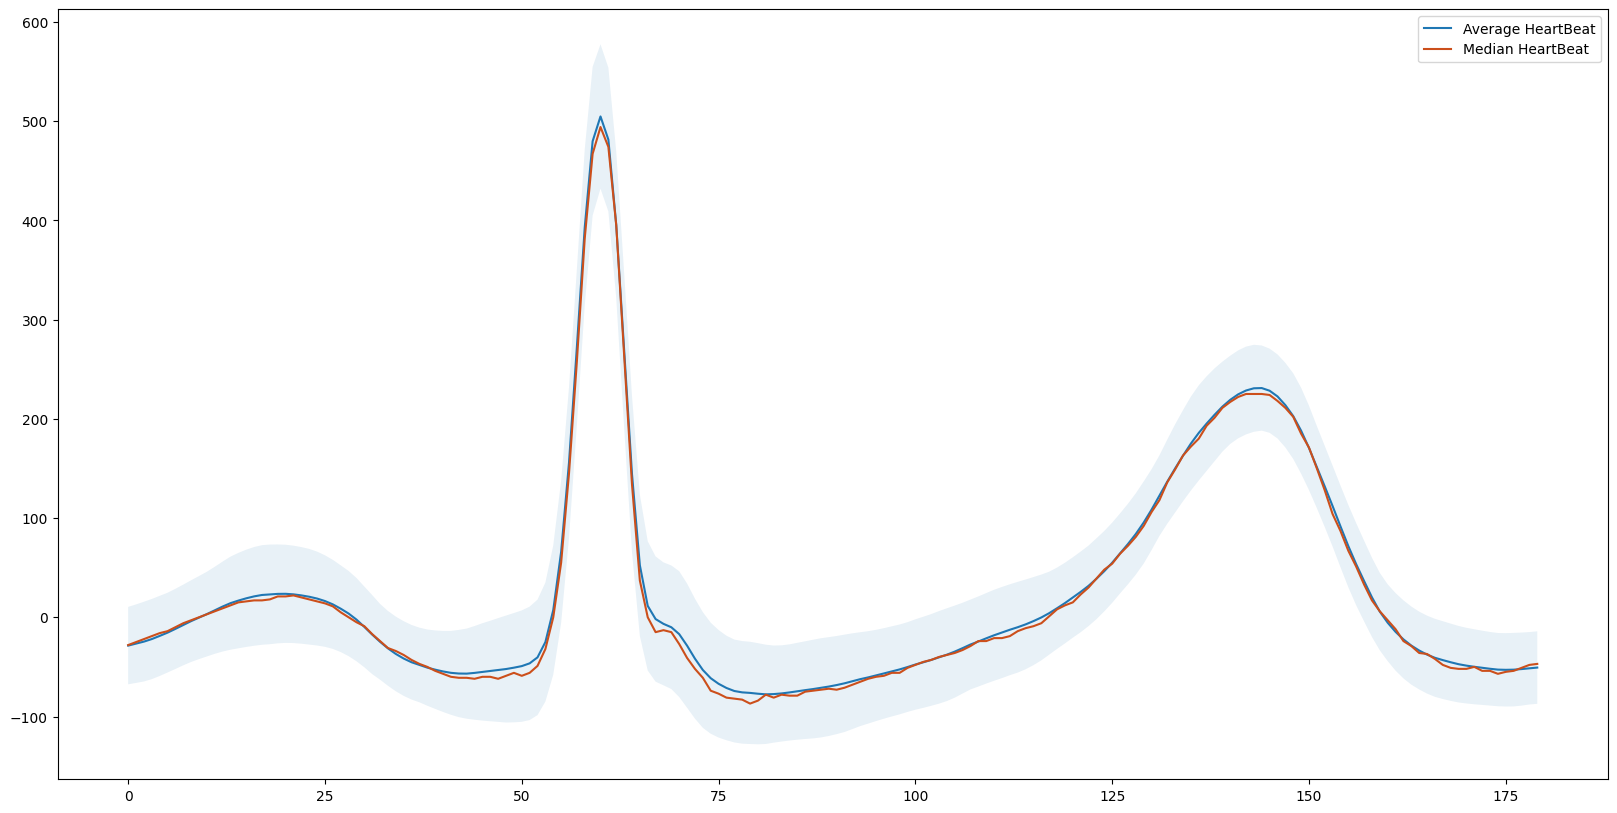

Processing val set: 100%|██████████| 1024/1024 [00:16<00:00, 61.14it/s]

(4093, 5, 181)
(1024, 5, 181)


In [58]:
def split_into_pulses(signal, idx, plot_first=True):
    r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
    if len(r_peaks) < 2:
        init_beat_length = np.array([len(signal)]).reshape(1)
        # Interpolate to length 180
        interp_func = interp1d(np.arange(len(signal)), signal, kind='linear', fill_value='extrapolate')
        resampled_indices = np.linspace(0, len(signal) - 1, 180)
        beats = interp_func(resampled_indices).reshape(1, -1)
    else:
        init_beat_length = np.mean([r_peaks[i + 1] - r_peaks[i] for i in range(len(r_peaks) - 1)]).reshape(1)
        beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']
    #print(beats.shape)
    mu = np.mean(beats, axis=0)
    var = np.std(beats, axis=0)
    md = np.median(beats, axis=0)
    maxs = np.max(beats, axis=0)
    mins = np.min(beats, axis=0)

    if idx == 0 and plot_first:
        plt.figure(figsize=(20, 10))
        plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')
        plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
        plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')
        plt.legend()
        plt.show()
    
    return mu, var, md, maxs, mins, init_beat_length

# Split into pulses and save as numpy arrays
train_processed = []
val_processed = []
for df_name, df, processed in zip(['train', 'val'], [train_df, val_df], [train_processed, val_processed]):
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc=f'Processing {df_name} set'):
        signal = np.array(row)
        signal = signal[~np.isnan(signal)] # Remove nan values
        mu, var, md, maxs, mins, lengths = split_into_pulses(signal, idx, plot_first=True)
        processed.append(np.vstack([mu, var, md, maxs, mins]))
        # add length as a feature
        processed[-1] = np.hstack([processed[-1], np.array([lengths]*5)])

train_processed = np.array(train_processed)
val_processed = np.array(val_processed)
train_y = train_y.to_numpy()
val_y = val_y.to_numpy()

print(train_processed.shape)
print(val_processed.shape)
    

In [68]:
# calculate snr for each entry in train_processed, print mean, std, min, max for each class

train_processed_0 = train_processed[train_y == 0]
train_processed_1 = train_processed[train_y == 1]
train_processed_2 = train_processed[train_y == 2]
train_processed_3 = train_processed[train_y == 3]

snrs_0 = [np.mean(train_processed_0[i][2]) for i in range(train_processed_0.shape[0])]
print(f"for class 0, mean snr is {np.mean(snrs_0)}, std is {np.std(snrs_0)}, min is {np.min(snrs_0)}, max is {np.max(snrs_0)}")

snrs_1 = [np.mean(train_processed_1[i][2]) for i in range(train_processed_1.shape[0])]
print(f"for class 1, mean snr is {np.mean(snrs_1)}, std is {np.std(snrs_1)}, min is {np.min(snrs_1)}, max is {np.max(snrs_1)}")

snrs_2 = [np.mean(train_processed_2[i][2]) for i in range(train_processed_2.shape[0])]
print(f"for class 2, mean snr is {np.mean(snrs_2)}, std is {np.std(snrs_2)}, min is {np.min(snrs_2)}, max is {np.max(snrs_2)}")

snrs_3 = [np.mean(train_processed_3[i][2]) for i in range(train_processed_3.shape[0])]
print(f"for class 3, mean snr is {np.mean(snrs_3)}, std is {np.std(snrs_3)}, min is {np.min(snrs_3)}, max is {np.max(snrs_3)}")

for class 0, mean snr is 25.236786503629087, std is 33.35446823352814, min is -366.9944751381216, max is 250.91988950276243
for class 1, mean snr is 17.763809594748864, std is 23.560094570425314, min is -48.844423092321236, max is 79.89173052931741
for class 2, mean snr is 22.376418629571322, std is 35.72216241806241, min is -333.28742436201, max is 185.49365999456572
for class 3, mean snr is 20.124786704620625, std is 49.71708797571994, min is -332.5939226519337, max is 172.64173395665108


In [80]:
# train liear regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(train_processed, train_y)
pred = clf.predict(val_processed)
print(accuracy_score(val_y, pred))

# train random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=0).fit(train_processed, train_y)
pred = clf.predict(val_processed)
print(accuracy_score(val_y, pred))

# train HistGradientBoostingClassifier model
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# create class weight based on the number of samples in each class
#class_weight = {0: 1, 1: 7, 2: 2}
clf = HistGradientBoostingClassifier(max_iter=5000, random_state=0).fit(train_processed, train_y)
pred = clf.predict(val_processed)
print(accuracy_score(val_y, pred))
print(f1_score(val_y, pred, average='macro'))

/home/glib/anaconda3/envs/sdfusion/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6424242424242425
0.705050505050505
0.7404040404040404
0.654803858674037


In [ ]:
# train HistGradientBoostingClassifier model
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# create class weight based on the number of samples in each class
#class_weight = {0: 1, 1: 7, 2: 2}
clf = HistGradientBoostingClassifier(max_iter=5000, random_state=0).fit(train_processed, train_y)
pred = clf.predict(val_processed)
print(accuracy_score(val_y, pred))
print(f1_score(val_y, pred, average='macro'))

In [34]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0):
        super(GRUModel, self).__init__()
        # self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.lstm = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #print(x.shape)
        #packed_output,(hidden_state,cell_state)= self.lstm(x)
        packed_output,hidden_state= self.lstm(x)
        # Assuming you want the last hidden state
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        
        # Max pooling across the sequence dimension
        #print('hidden', hidden.shape)
        #out, out2 = torch.max(hidden, dim=1)
        #print('out', out.shape, out2.shape)
        out = hidden
        out = self.fc1(out)
        out = self.relu(out)
        # Uncomment the line below if you want to apply dropout
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
    def softmax(self, x):
        return torch.softmax(x, dim=-1)
    

class CustomDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index]).float() #.unsqueeze(-1) # uncomment for RNNs with 1d input
        # transpose to (batch, seq_len, input_size)
        #print(sequence.shape)
        sequence = sequence.transpose(0, 1)
        #print(sequence.shape)
        label = torch.tensor(self.labels[index])
        return sequence, label
    

def train(model, num_epochs, batch_size, learning_rate, train_df, train_y, val_df, val_y, weights_dir='weights'):
    train_dataset = CustomDataset(train_df, train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = CustomDataset(val_df, val_y)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class_weights_normalized = np.array([1.69, 11.6, 3.47, 30])/np.sum([1.69, 11.6, 3.47, 30]) #[0.1, 0.7, 0.2]
    class_weights = torch.FloatTensor(class_weights_normalized).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    model.to(device)

    os.makedirs(weights_dir, exist_ok=True)

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for sequences, labels in train_loader: #tqdm(train_loader):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            l2_reg = torch.tensor(0.0).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, p=2)
            loss += learning_rate * l2_reg
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for sequences, labels in val_loader:
                #print(labels)
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                test_loss = criterion(outputs, labels)
                outputs = model.softmax(outputs)
                _, predicted = torch.max(outputs.data, 1)
                predicted_np = outputs.cpu().numpy()
                #print(predicted_np)
                #print(np.unique(predicted_np, return_counts=True))
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')

            accuracy = correct / total
            print(f'Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss/len(train_loader):.4f}, Val loss: {test_loss.item():.4f}, Validation Accuracy: {accuracy:.2%}, F1 score: {f1:.4f}')
            torch.save(model.state_dict(), f'{weights_dir}/gru_epoch_{epoch+1}.pth')


In [35]:
print(train_processed.shape)

(3957, 5, 181)


In [37]:
input_size = 5 # train_processed.shape[1]
hidden_size = 256
output_size = 3 
batch_size = 64
num_epochs = 30
learning_rate = 0.0001

model = GRUModel(input_size, hidden_size, output_size, num_layers=6, dropout=0.5)

train(model, num_epochs, batch_size, learning_rate, train_processed, train_y, val_processed, val_y, weights_dir='weights')

Epoch 1/30, Train loss: 1.1360, Val loss: 1.1096, Validation Accuracy: 43.43%, F1 score: 0.0952
Epoch 2/30, Train loss: 1.1135, Val loss: 0.9831, Validation Accuracy: 43.64%, F1 score: 0.1538
Epoch 3/30, Train loss: 1.0808, Val loss: 1.0628, Validation Accuracy: 43.74%, F1 score: 0.1538
Epoch 4/30, Train loss: 1.0347, Val loss: 1.1281, Validation Accuracy: 47.58%, F1 score: 0.1538
Epoch 5/30, Train loss: 0.9920, Val loss: 1.1096, Validation Accuracy: 51.01%, F1 score: 0.1667
Epoch 6/30, Train loss: 0.9500, Val loss: 0.9218, Validation Accuracy: 49.70%, F1 score: 0.2585
Epoch 7/30, Train loss: 0.9168, Val loss: 0.9070, Validation Accuracy: 55.96%, F1 score: 0.2222
Epoch 8/30, Train loss: 0.8921, Val loss: 0.8796, Validation Accuracy: 54.95%, F1 score: 0.2121
Epoch 9/30, Train loss: 0.8642, Val loss: 0.9208, Validation Accuracy: 57.27%, F1 score: 0.2121
Epoch 10/30, Train loss: 0.8568, Val loss: 0.7872, Validation Accuracy: 56.77%, F1 score: 0.2319
Epoch 11/30, Train loss: 0.8355, Val lo

KeyboardInterrupt: 

In [208]:
class Big1DCNN(nn.Module):
    def __init__(self, input_size, num_classes, dropout=0.1):
        super(Big1DCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024 * (input_size // 32), 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def softmax(self, x):
        return torch.softmax(x, dim=-1)

In [ ]:
input_size = 901 # train_processed.shape[1]
hidden_size = 256
output_size = 3 
batch_size = 64
num_epochs = 30
learning_rate = 0.0001

cn = Big1DCNN(input_size, output_size, dropout=0.1)

train(cn, num_epochs, batch_size, learning_rate, train_processed, train_y, val_processed, val_y, weights_dir='weights_cn')

In [212]:
class Improved1DCNN(nn.Module):
    def __init__(self, input_size, num_classes, dropout=0.5):
        super(Improved1DCNN, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (input_size // 4), 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def softmax(self, x):
        return torch.softmax(x, dim=-1)


In [225]:
input_size = 901 # train_processed.shape[1]
hidden_size = 64
output_size = 3 
batch_size = 64
num_epochs = 30
learning_rate = 0.001


icn = Improved1DCNN(input_size, output_size, dropout=0.2)

train(icn, num_epochs, batch_size, learning_rate, train_processed, train_y, val_processed, val_y, weights_dir='weights_icn')

Epoch 1/30, Train loss: 35.5069, Val loss: 1.0994, Validation Accuracy: 52.83%, F1 score: 0.1404
Epoch 2/30, Train loss: 1.1079, Val loss: 1.1656, Validation Accuracy: 58.48%, F1 score: 0.0784
Epoch 3/30, Train loss: 1.0715, Val loss: 1.1593, Validation Accuracy: 59.19%, F1 score: 0.1261
Epoch 4/30, Train loss: 1.0188, Val loss: 0.9436, Validation Accuracy: 55.25%, F1 score: 0.2016
Epoch 5/30, Train loss: 0.9384, Val loss: 1.1406, Validation Accuracy: 55.45%, F1 score: 0.1261
Epoch 6/30, Train loss: 0.8910, Val loss: 1.2064, Validation Accuracy: 50.51%, F1 score: 0.1905
Epoch 7/30, Train loss: 0.8207, Val loss: 1.3435, Validation Accuracy: 55.86%, F1 score: 0.1667
Epoch 8/30, Train loss: 0.7566, Val loss: 1.3696, Validation Accuracy: 56.06%, F1 score: 0.2411
Epoch 9/30, Train loss: 0.7219, Val loss: 1.4438, Validation Accuracy: 56.67%, F1 score: 0.1905
Epoch 10/30, Train loss: 0.6909, Val loss: 1.8518, Validation Accuracy: 56.06%, F1 score: 0.1789
Epoch 11/30, Train loss: 0.6519, Val l

In [45]:
class SmallCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.5):
        super(SmallCNN, self).__init__()

        self.conv1 = nn.Conv1d(5, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (input_size // 4), hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def softmax(self, x):
        return torch.softmax(x, dim=-1)

In [46]:
print(train_processed.shape)

(3957, 5, 181)


In [53]:
input_size = 181 # train_processed.shape[1]
hidden_size = 64
output_size = 3 
batch_size = 64
num_epochs = 30
learning_rate = 0.005

scn = SmallCNN(input_size, hidden_size, output_size, dropout=0.5)

train_processed_t = train_processed.transpose(0, 2, 1)
val_processed_t = val_processed.transpose(0, 2, 1)

train(scn, num_epochs, batch_size, learning_rate, train_processed_t, train_y, val_processed_t, val_y, weights_dir='weights_scn')

Epoch 1/30, Train loss: 5.2803, Val loss: 1.1309, Validation Accuracy: 10.20%, F1 score: 0.0000
Epoch 2/30, Train loss: 1.2510, Val loss: 1.1287, Validation Accuracy: 60.10%, F1 score: 0.0000
Epoch 3/30, Train loss: 1.2435, Val loss: 1.1020, Validation Accuracy: 60.71%, F1 score: 0.0000
Epoch 4/30, Train loss: 1.2380, Val loss: 1.0956, Validation Accuracy: 60.81%, F1 score: 0.0000
Epoch 5/30, Train loss: 1.2331, Val loss: 1.1040, Validation Accuracy: 58.69%, F1 score: 0.0000
Epoch 6/30, Train loss: 1.2306, Val loss: 1.1233, Validation Accuracy: 61.21%, F1 score: 0.0000
Epoch 7/30, Train loss: 1.2293, Val loss: 1.1162, Validation Accuracy: 61.21%, F1 score: 0.0000
Epoch 8/30, Train loss: 1.2265, Val loss: 1.1097, Validation Accuracy: 61.21%, F1 score: 0.0000
Epoch 9/30, Train loss: 1.2237, Val loss: 1.1050, Validation Accuracy: 61.21%, F1 score: 0.0000
Epoch 10/30, Train loss: 1.2213, Val loss: 1.1214, Validation Accuracy: 61.21%, F1 score: 0.0000
Epoch 11/30, Train loss: 1.2193, Val lo